In [1]:
import pandas as pd

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/tanzania/'

train_features = pd.read_csv(LOCAL + 'train_features.csv')
train_labels = pd.read_csv(LOCAL + 'train_labels.csv')
test_features = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [2]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [3]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Features
Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

<b>amount_tsh :</b> Total static head (amount water available to waterpoint)<br>
<b>date_recorded :</b> The date the row was entered<br>
<b>funder :</b> Who funded the well<br>
<b>gps_height :</b> Altitude of the well<br>
<b>installer :</b> Organization that installed the well<br>
<b>longitude :</b> GPS coordinate<br>
<b>latitude :</b> GPS coordinate<br>
<b>wpt_name :</b> Name of the waterpoint if there is one<br>
<b>num_private :</b><br>
<b>basin :</b> Geographic water basin<br>
<b>subvillage :</b> Geographic location<br>
<b>region :</b> Geographic location<br>
<b>region_code :</b> Geographic location (coded)<br>
<b>district_code :</b> Geographic location (coded)<br>
<b>lga :</b> Geographic location<br>
<b>ward :</b> Geographic location<br>
<b>population :</b> Population around the well<br>
<b>public_meeting :</b> True/False<br>
<b>recorded_by :</b> Group entering this row of data<br>
<b>scheme_management :</b> Who operates the waterpoint<br>
<b>scheme_name :</b> Who operates the waterpoint<br>
<b>permit :</b> If the waterpoint is permitted<br>
<b>construction_year :</b> Year the waterpoint was constructed<br>
<b>extraction_type :</b> The kind of extraction the waterpoint uses<br>
<b>extraction_type_group :</b> The kind of extraction the waterpoint uses<br>
<b>extraction_type_class :</b> The kind of extraction the waterpoint uses<br>
<b>management :</b> How the waterpoint is managed<br>
<b>management_group :</b> How the waterpoint is managed<br>
<b>payment :</b> What the water costs<br>
<b>payment_type :</b> What the water costs<br>
<b>water_quality :</b> The quality of the water<br>
<b>quality_group :</b> The quality of the water<br>
<b>quantity :</b> The quantity of water<br>
<b>quantity_group :</b> The quantity of water<br>
<b>source :</b> The source of the water<br>
<b>source_type :</b> The source of the water<br>
<b>source_class :</b> The source of the water<br>
<b>waterpoint_type :</b> The kind of waterpoint<br>
<b>waterpoint_type_group :</b> The kind of waterpoint<br>
    
### Labels
There are three possible values:

<b>functional :</b> the waterpoint is operational and there are no repairs needed<br>
<b>functional needs repair :</b> the waterpoint is operational, but needs repairs<br>
<b>non functional :</b> the waterpoint is not operational<br>

### Baseline model with majority class

In [5]:
y_train = train_labels['status_group']
y_train.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [6]:
y_train.mode()[0]

'functional'

In [7]:
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)

In [8]:
y_pred[:5]

['functional', 'functional', 'functional', 'functional', 'functional']

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.543080808080808

In [11]:
train_features.shape

(59400, 40)

### Split data into train and validate set

In [12]:
from sklearn.model_selection import train_test_split

X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train)

In [13]:
X_train.shape, X_val.shape

((44550, 40), (14850, 40))

In [14]:
y_train.value_counts(normalize=True)

functional                 0.543075
non functional             0.384242
functional needs repair    0.072682
Name: status_group, dtype: float64

In [15]:
y_val.value_counts(normalize=True)

functional                 0.543098
non functional             0.384242
functional needs repair    0.072660
Name: status_group, dtype: float64

# Use Sklearn Logistic Regression

### Drop non-numeric features and nulls if necessary

In [16]:
X_train_numeric = X_train.select_dtypes('number')
X_val_numeric = X_val.select_dtypes('number')

X_train_numeric.shape, X_val_numeric.shape

((44550, 10), (14850, 10))

In [17]:
X_train_numeric.isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

### Fit Logistic Regression on train data

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train_numeric, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Evaluate on validation data

In [21]:
y_pred = model.predict(X_val_numeric)

y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype=object)

In [22]:
accuracy_score(y_val, y_pred)

0.5516498316498316

In [23]:
pd.Series(y_pred).value_counts()

functional        13485
non functional     1365
dtype: int64

# One Hot Encoding of Categorical Features

### Check "cardinality" of categorical features

In [25]:
X_train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,44550,1,GeoData Consultants Ltd,44550
public_meeting,42082,2,True,38275
permit,42257,2,True,29099
source_class,44550,3,groundwater,34365
management_group,44550,5,user-group,39428
quantity_group,44550,5,enough,24909
quantity,44550,5,enough,24909
waterpoint_type_group,44550,6,communal standpipe,25910
quality_group,44550,6,good,38044
payment_type,44550,7,never pay,19035


### Explore 'quantity' feature

In [26]:
X_train['quantity'].value_counts(dropna=False)

enough          24909
insufficient    11376
dry              4628
seasonal         3039
unknown           598
Name: quantity, dtype: int64

### Encode 'quantity' feature

In [27]:
import category_encoders as ce

In [28]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train['quantity'])

encoded.sample(10)

,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_dry,quantity_unknown
38059,1,0,0,0,0
25724,1,0,0,0,0
30593,1,0,0,0,0
58256,1,0,0,0,0
47894,0,1,0,0,0
19151,1,0,0,0,0
38934,1,0,0,0,0
46740,1,0,0,0,0
54604,0,1,0,0,0
19898,0,0,0,1,0


### encode and scale features

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
cat_features = ['quantity']
num_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = cat_features + num_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

scaler = StandardScaler()
X_train_subset[num_features] = scaler.fit_transform(X_train_subset[num_features])
X_val_subset[num_features] = scaler.transform(X_val_subset[num_features])

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train_encoded, y_train)
print('Validation Accuracy', model.score(X_val_encoded, y_val))

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Validation Accuracy 0.6556228956228957


In [31]:
categorical_features = ['quantity']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.6556228956228957


### Compare original features, encoded features, and scaled features

In [32]:
X_train[:1]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
35240,28252,200.0,2011-03-09,NaN,1757,Angli,34.58874,-9.786994,none,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [33]:
X_train_numeric[:1]

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
35240,28252,200.0,1757,34.58874,-9.786994,0,11,5,75,2001


In [34]:
X_train_scaled[:1]

array([[ 0.88798096, -0.58559299, -0.27057256, -0.34047916, -0.1166437 ,
        -0.03806493,  1.56900669,  0.07752458, -1.38406357, -0.03545445,
        -0.24241629, -0.06327462, -0.2264897 ,  0.73482189]])

### Get and Plot Coefficients

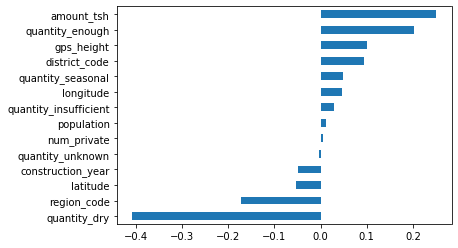

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt

coefs = pd.Series(model.coef_[0], X_train_encoded.columns)
coefs.sort_values().plot.barh();